In [142]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sympy as sp

from astropy import units as u
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.optimize import approx_fprime

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# model consts
h70=1
P0=6.85
c500=1.09
gamma=0.31
alpha=1.07
beta=5.46

gamma_b=4./3.


In [29]:
def E(z): #ratio of the Hubble constant at redshift z to its present value
    return cosmo.H(z)/cosmo.H(0)

In [73]:
def P500(z, M500):
    M500=M500.to(u.Msun)
    return ((1.65*1e-3*E(z)**(8/3)
            *(M500/(3*1e14*h70**(-1)*u.Msun))**2/3 
            *h70**2 * u.keV * u.cm**-3)).to(u.erg/u.cm**3, equivalencies=u.mass_energy()) 

In [158]:
def Pg(x, z, M500): #x=r/r500
    return (P0*P500(z, M500) #units keVcm-3
           / ((c500*x)**gamma  #unitless
              * (1+ (c500*x)**alpha)**((beta-gamma)/alpha))).to(u.erg/u.cm**3, equivalencies=u.mass_energy())

def Pg_r(r, z, M500, R500):
    return Pg(r/R500, z, M500)

def log_Pg(x, z, M500):
    return np.log((Pg(x, z, M500)).to(u.erg*u.cm**-3).value)

Text(0, 0.5, 'Pg (erg/cm3)')

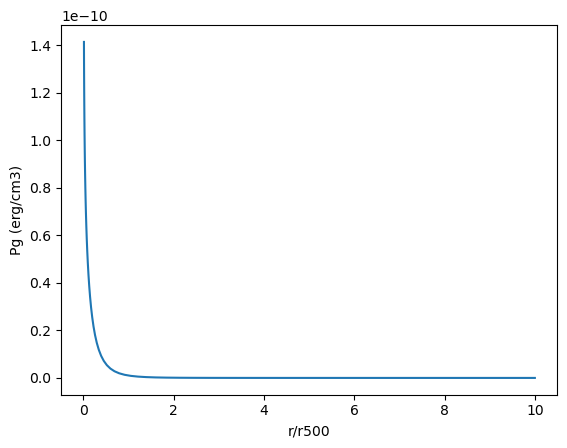

In [177]:
x=np.logspace(-2, 1)
z=3, 
M500=1e14*u.Msun
plt.plot(x, Pg(x, z, M500).to(u.erg*u.cm**-3))
plt.xlabel('r/r500')
plt.ylabel('Pg (erg/cm3)')

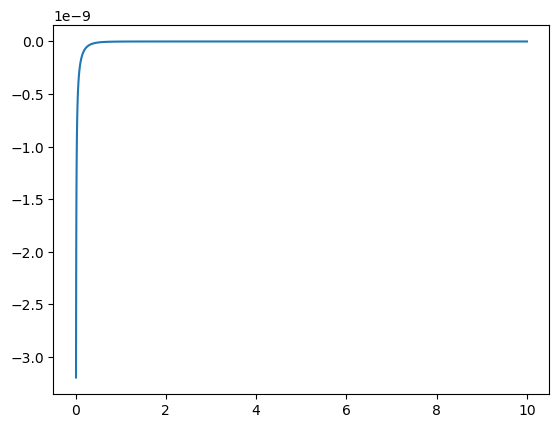

In [179]:
r=np.logspace(-2, 1)*R500
plt.plot(r, dP_dr(r, R500, M500, z))
plt.xlabel('r(Mpc)')
plt.ylabel()

In [181]:
dP_dr(r, R500, M500, z)

<Quantity [-3.19607493e-09, -2.70080783e-09, -2.28630269e-09,
           -1.93890856e-09, -1.64727224e-09, -1.40195275e-09,
           -1.19510148e-09, -1.02019691e-09, -8.71824981e-10,
           -7.45497141e-10, -6.37499965e-10, -5.44770671e-10,
           -4.64793978e-10, -3.95516199e-10, -3.35273050e-10,
           -2.82728012e-10, -2.36818543e-10, -1.96707861e-10,
           -1.61740580e-10, -1.31401177e-10, -1.05275060e-10,
           -8.30128417e-11, -6.42991561e-11, -4.88277569e-11,
           -3.62845532e-11, -2.63396002e-11, -1.86479303e-11,
           -1.28577732e-11, -8.62355121e-12, -5.62040898e-12,
           -3.55715130e-12, -2.18526423e-12, -1.30291405e-12,
           -7.54068469e-13, -4.23827938e-13, -2.31512075e-13,
           -1.23025339e-13, -6.36765702e-14, -3.21465838e-14,
           -1.58535207e-14, -7.64994730e-15, -3.61793515e-15,
           -1.67982873e-15, -7.66995627e-16, -3.44939771e-16,
           -1.53032059e-16, -6.70713495e-17, -2.90796868e-17,
        

In [171]:
def dP_dr(rs, R500, M500, z):
    rs=rs.to(u.Mpc).value
    R500=R500.to(u.Mpc).value
    return [approx_fprime(r, Pg_r, r, z, M500, R500)[0] for r in rs]*(u.erg/(u.cm**3 * u.Mpc))

def integrand(r, R500, M500, z):
    x=r/R500
    return ((Pg(x, z, M500))**((gamma_b-1)/gamma_b)
            *(1/r)
            *dP_dr(r, R500, M500, z)
            *(1-np.exp(-1*r/r0))
            *np.exp(-1*r/rc))
    
def q(r, R500, M500, z):
    rini=0.015*R500.to(u.cm)
    rmax=R500.to(u.cm)
    print(integrand(rini, R500, M500, z))
    return quad(integrand, rini, rmax, args=(R500, M500, z))

In [40]:
def h(Linj, r, r0, rc, q):
    return (Linj/(4*np.pi*r**2)
            *(1-np.exp(-1*r/r0))
            *np.exp(-1*r/rc)
            *(1/q))

In [41]:
def vol_heating_rate(r, R500, M500, z, Linj):
    x=r/R500
    r0=(0.015*R500).to(u.cm)
    rc=(0.1*R500).to(u.cm)
    return (h(Linj, r, r0, rc, q(r, R500, M500, z))
        *(Pg(x, z, M500))**((gamma_b-1)/gamma_b)
        *(1/r)
        *dP_dr(r, R500, M500, z)) #derivative

In [62]:
r=1*u.Mpc
R500=1*u.Mpc
M500=1e14*u.Msun
z=1
Linj=1e45*u.erg/u.s
vol_heating_rate(r, R500, M500, z, Linj)

UnitConversionError: 'erg2 keV / (cm3 solMass2)' and 'erg / cm3' (energy density/pressure/stress) are not convertible

In [74]:
#dP_dr(R500.to(u.cm), R500.to(u.cm), M500.to(u.erg, equivalencies=u.mass_energy()), z)
Pg(1, z, M500)


4.425674802405817e-13 erg / cm3


<Quantity 8.36741046e-14 erg / cm3>

In [83]:
dP_dr(R500, R500, M500, z)

4.425674802405817e-13 erg / cm3
4.425674802405817e-13 erg / cm3


array([-7.60938085e-14])

Text(0, 0.5, 'Pg (erg/cm3)')

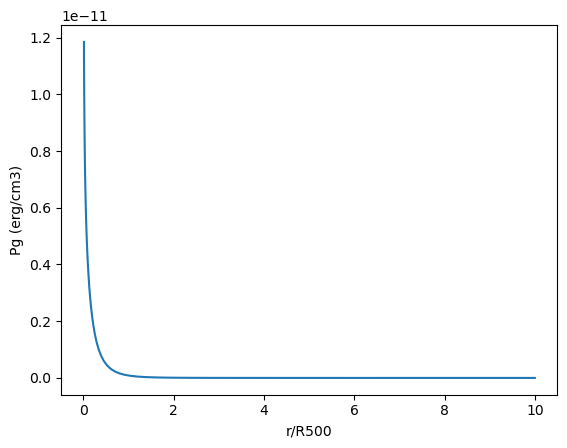

In [175]:
r=np.logspace(-2, 1)*R500
plt.plot(r/R500, Pg(r/R500, 1, M500))
plt.xlabel('r/R500')
plt.ylabel('Pg (erg/cm3)')

In [173]:
dP_dr(r, R500, M500, z)

<Quantity [-2.67893253e-10, -2.26380235e-10, -1.91636641e-10,
           -1.62518256e-10, -1.38073459e-10, -1.17510913e-10,
           -1.00172752e-10, -8.55123473e-11, -7.30758931e-11,
           -6.24871627e-11, -5.34348984e-11, -4.56623798e-11,
           -3.89587771e-11, -3.31519515e-11, -2.81024037e-11,
           -2.36981074e-11, -1.98500008e-11, -1.64879453e-11,
           -1.35570069e-11, -1.10139748e-11, -8.82409798e-12,
           -6.95809100e-12, -5.38952011e-12, -4.09271588e-12,
           -3.04135141e-12, -2.20777089e-12, -1.56305932e-12,
           -1.07773152e-12, -7.22821347e-13, -4.71099607e-13,
           -2.98158477e-13, -1.83167653e-13, -1.09209543e-13,
           -6.32056068e-14, -3.55250260e-14, -1.94052155e-14,
           -1.03119166e-14, -5.33733529e-15, -2.69450907e-15,
           -1.32883343e-15, -6.41214400e-16, -3.03253346e-16,
           -1.40802326e-16, -6.42891540e-17, -2.89126630e-17,
           -1.28270635e-17, -5.62188384e-18, -2.43744344e-18,
        

In [160]:
Pg_r(r, z, M500, R500)

<Quantity [1.18448042e-11, 1.12685413e-11, 1.07096530e-11, 1.01667494e-11,
           9.63847502e-12, 9.12351554e-12, 8.62060964e-12, 8.12856396e-12,
           7.64627313e-12, 7.17274519e-12, 6.70713303e-12, 6.24877193e-12,
           5.79722322e-12, 5.35232281e-12, 4.91423280e-12, 4.48349248e-12,
           4.06106388e-12, 3.64836449e-12, 3.24727870e-12, 2.86013763e-12,
           2.48965748e-12, 2.13882828e-12, 1.81074936e-12, 1.50841584e-12,
           1.23447004e-12, 9.90942960e-13, 7.79020555e-13, 5.98873232e-13,
           4.49583382e-13, 3.29191972e-13, 2.34864057e-13, 1.63149181e-13,
           1.10293219e-13, 7.25493910e-14, 4.64407789e-14, 2.89425821e-14,
           1.75736324e-14, 1.04063024e-14, 6.01670393e-15, 3.40124321e-15,
           1.88267552e-15, 1.02198871e-15, 5.44925585e-16, 2.85846964e-16,
           1.47741865e-16, 7.53508695e-17, 3.79746326e-17, 1.89358563e-17,
           9.35371692e-18, 4.58214102e-18] erg / cm3>

In [169]:
epsilon=np.sqrt(np.finfo(float).eps)*u.Mpc
(Pg_r(r+epsilon, z, M500, R500) - Pg_r(r, z, M500, R500))/epsilon

<Quantity [-4.15266395e-10, -3.49525472e-10, -2.94644864e-10,
           -2.48791958e-10, -2.10442554e-10, -1.78328909e-10,
           -1.51396580e-10, -1.28768571e-10, -1.09715585e-10,
           -9.36313375e-11, -8.00120988e-11, -6.84397575e-11,
           -5.85678107e-11, -5.01097888e-11, -4.28296873e-11,
           -3.65340474e-11, -3.10653657e-11, -2.62965469e-11,
           -2.21261521e-11, -1.84742159e-11, -1.52784451e-11,
           -1.24906529e-11, -1.00733478e-11, -7.99646853e-12,
           -6.23433979e-12, -4.76300156e-12, -3.55810590e-12,
           -2.59357279e-12, -1.84111882e-12, -1.27064957e-12,
           -8.51345195e-13, -5.53141764e-13, -3.48248491e-13,
           -2.12374237e-13, -1.25453300e-13, -7.18131846e-14,
           -3.98655430e-14, -2.14847733e-14, -1.12561217e-14,
           -5.74182594e-15, -2.85667132e-15, -1.38869878e-15,
           -6.60847965e-16, -3.08424304e-16, -1.41429371e-16,
           -6.38313954e-17, -2.84022026e-17, -1.24785702e-17,
        

In [107]:
#plt.plot(r, dP_dr(r, R500, M500, z)[0])
#plt.xscale('log')
#plt.yscale('symlog')

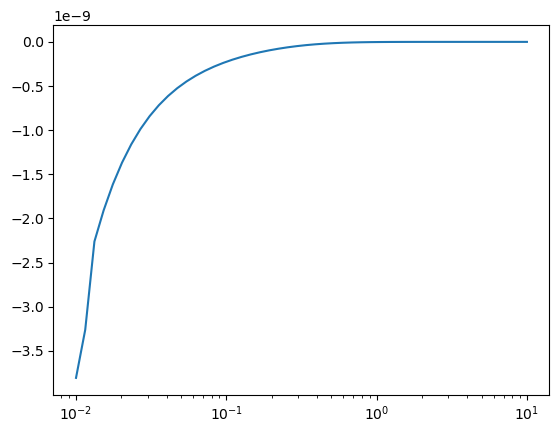

In [138]:
dr = np.insert(np.diff(r), 0, 0.9*np.diff(r)[0])
plt.plot(r, np.gradient(Pg(r/R500, 1, M500), dr))
plt.xscale('log')


In [139]:
dr

<Quantity [0.00136256, 0.00151395, 0.00174316, 0.00200707, 0.00231093,
           0.00266079, 0.00306362, 0.00352744, 0.00406148, 0.00467637,
           0.00538435, 0.00619951, 0.00713809, 0.00821876, 0.00946305,
           0.01089571, 0.01254527, 0.01444457, 0.01663141, 0.01914933,
           0.02204845, 0.02538648, 0.02922988, 0.03365514, 0.03875038,
           0.04461701, 0.05137182, 0.05914927, 0.0681042 , 0.07841486,
           0.09028651, 0.10395548, 0.11969386, 0.13781496, 0.15867951,
           0.18270285, 0.21036323, 0.24221125, 0.27888092, 0.32110221,
           0.3697156 , 0.42568884, 0.49013618, 0.56434054, 0.6497791 ,
           0.74815267, 0.86141954, 0.99183449, 1.14199367, 1.31488626] Mpc>

In [131]:
np.diff(r)[0]

<Quantity 0.00151395 Mpc>

In [126]:
np.gradient(r, np.concatenate(Pg(r/R500, 1, M500), Pg(r/R500, 1, M500)[:-1]))

TypeError: only integer dimensionless scalar quantities can be converted to a Python index

In [115]:
Pg(r/R500, 1, M500)

<Quantity [1.18448042e-11, 1.12685413e-11, 1.07096530e-11, 1.01667494e-11,
           9.63847502e-12, 9.12351554e-12, 8.62060964e-12, 8.12856396e-12,
           7.64627313e-12, 7.17274519e-12, 6.70713303e-12, 6.24877193e-12,
           5.79722322e-12, 5.35232281e-12, 4.91423280e-12, 4.48349248e-12,
           4.06106388e-12, 3.64836449e-12, 3.24727870e-12, 2.86013763e-12,
           2.48965748e-12, 2.13882828e-12, 1.81074936e-12, 1.50841584e-12,
           1.23447004e-12, 9.90942960e-13, 7.79020555e-13, 5.98873232e-13,
           4.49583382e-13, 3.29191972e-13, 2.34864057e-13, 1.63149181e-13,
           1.10293219e-13, 7.25493910e-14, 4.64407789e-14, 2.89425821e-14,
           1.75736324e-14, 1.04063024e-14, 6.01670393e-15, 3.40124321e-15,
           1.88267552e-15, 1.02198871e-15, 5.44925585e-16, 2.85846964e-16,
           1.47741865e-16, 7.53508695e-17, 3.79746326e-17, 1.89358563e-17,
           9.35371692e-18, 4.58214102e-18] erg / cm3>